In [5]:
import numpy as np
import cv2
import glob
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pickle
from skimage.metrics import structural_similarity as ssim

Загрузка путей к картинкам

In [6]:
images = glob.glob('flowers/**/*.jpg')
print(len(images))

13838


Преобразование картинок к численному массиву

In [7]:
def img_to_arr(path):
    return image.img_to_array(image.load_img(path, target_size=(100, 100, 3)))/255.0
images = np.array(list(map(img_to_arr, images)))

Разделение на обучающую и тестовую выборки

In [8]:
x_train, x_test = train_test_split(images, random_state = 10, test_size=0.8)

In [9]:
#функция для ухудшения качества изображения, сохраняя его разрешение
def compress_image(image, percent = 0.40):
    # сжимаем картинке на percent (40% в нашем случае)
    image_ = cv2.resize(image, (int(image.shape[1] * percent), int(image.shape[0] * percent)), interpolation = cv2.INTER_AREA)
    # возращаем исходный размер после сжатия
    compr_image = cv2.resize(image_, (image.shape[1], image.shape[0]), interpolation =  cv2.INTER_AREA)
    return compr_image

Проверяем её работоспособность

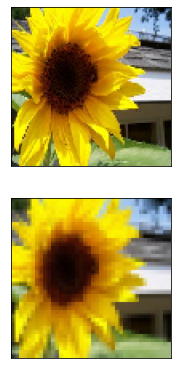

In [11]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(3, 1, 1)
plt.imshow(x_train[46])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(3, 1, 2)
plt.imshow(compress_image(x_train[46]))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [12]:
# сжимаем все изображения для обучения
train_LR_images = []
for i in x_train:
    train_LR_images.append(compress_image(i))
train_LR_images = np.array(train_LR_images)
test_LR_images = []
for i in x_test:
    test_LR_images.append(compress_image(i))
test_LR_images = np.array(test_LR_images)

Функция с нашими метриками

In [13]:
def custom_metrics(f, s):
    diff = (s - f).flatten('C')
    rmse = np.sqrt(np.mean(diff ** 2.))
    psnr = 20 * np.log10(255. / rmse)
    err = np.sum((f - s) ** 2)
    mse = err / (f.shape[0] * f.shape[1])
    ssim_ = ssim(f, s, multichannel=True)
    print(f'psnr {psnr}')
    print(f'mse {mse}')
    print(f'ssim {ssim_}')

Первоначальная структура нашей модели.

На вход мы подаём изображение размером 100х100 пикселей с 3 каналами (RGB). Наша модель будет состоять из 8 слоёв, с одним этапом MaxPooling, шаг свёртки 2 на 2, функцией активации укажем свойственную большинству СНН – relu, padding=’same’, чтобы размер входа оставался таким же. Чтобы устранить возможность переобучения, воспользуемся методом регуляризации L1 в слоях свёртки. Используем алгоритм оптимизации Адама, так как он довольно эффективен при большом количестве параметров и требует относительно небольшого объёма памяти, функцию потерь mse и метрику accuracy, вычисляющую как часто прогнозы верны.

In [14]:
in_img = Input(shape=(100, 100, 3))  

#Энкодер
x1 = Conv2D(70, (2, 2), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(in_img)
x2 = MaxPool2D(padding='same')(x1)
encoder = Conv2D(130, (2, 2), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x2)
#Декодер
x3 = UpSampling2D()(encoder)
x4 = Conv2D(70, (2, 2), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Add()([x1, x4])
decoder = Conv2D(3, (2, 2), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x5)
autoencoder = Model(in_img, decoder)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [15]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 100, 70) 910         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 50, 50, 70)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 50, 130)  36530       max_pooling2d[0][0]              
______________________________________________________________________________________________

Добавим EarlyStopping, чтобы остановить обучение, когда отслеживаемый показатель перестанет улучшаться на протяжении 5 эпох и checkpoint, чтобы сохранять лучшую модель.

In [16]:
es = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=1, mode='min')
checkpoint = ModelCheckpoint('checkpoint.h5', save_best_only = True)

Запускаем обучение с 10 эпохами.

In [17]:
history = autoencoder.fit(train_LR_images, x_train, epochs=10, validation_data=(test_LR_images, x_test), callbacks=[es, checkpoint])

Epoch 1/10
87/87 [==============================] - 666s 7s/step - loss: 0.0223 - accuracy: 0.7507 - val_loss: 0.0071 - val_accuracy: 0.8398


D:\conda\envs\new_env\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
87/87 [==============================] - 657s 7s/step - loss: 0.0063 - accuracy: 0.8660 - val_loss: 0.0062 - val_accuracy: 0.8738
Epoch 3/10
87/87 [==============================] - 744s 8s/step - loss: 0.0056 - accuracy: 0.8844 - val_loss: 0.0056 - val_accuracy: 0.8738
Epoch 4/10
87/87 [==============================] - 697s 8s/step - loss: 0.0054 - accuracy: 0.8887 - val_loss: 0.0055 - val_accuracy: 0.8857
Epoch 5/10
87/87 [==============================] - 621s 7s/step - loss: 0.0053 - accuracy: 0.8958 - val_loss: 0.0055 - val_accuracy: 0.9033
Epoch 6/10
87/87 [==============================] - 703s 8s/step - loss: 0.0052 - accuracy: 0.9013 - val_loss: 0.0054 - val_accuracy: 0.8972
Epoch 00006: early stopping


Тестируем

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


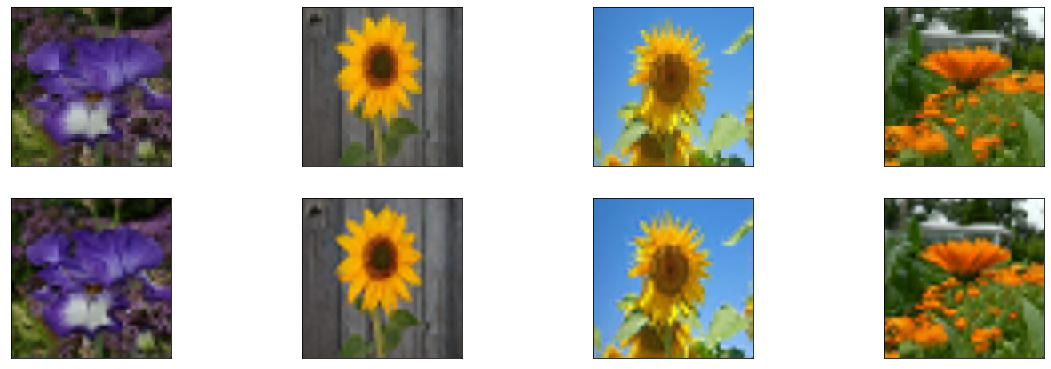

In [27]:
predictions = autoencoder.predict(test_LR_images[:100])
n = 4
plt.figure(figsize=(20, 10))
offset = 59
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(test_LR_images[i+offset])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(predictions[i+offset])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Оценим нашу модель на тестовых данных, используя встроенный метод "evaluate", метрики и графики показателей accuracy и loss

In [30]:
res = autoencoder.evaluate(test_LR_images, x_test)
print(f'val_loss = {res[0]}, val_accuracy = {res[1]}')

346/346 [==============================] - 333s 956ms/step - loss: 0.0054 - accuracy: 0.8972
val_loss = 0.00540718762204051, val_accuracy = 0.8971967101097107


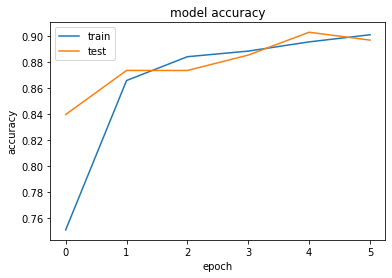

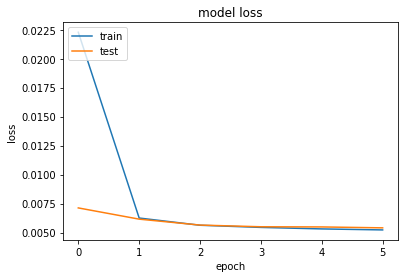

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
num_of_img = 60
custom_metrics(x_test[num_of_img], test_LR_images[num_of_img])
print('-'*30)
custom_metrics(x_test[num_of_img], predictions[num_of_img])

psnr 73.98460311033388
mse 0.007793656921386719
ssim 0.8325505256652832
------------------------------
psnr 74.45621830148329
mse 0.0069916511535644535
ssim 0.8429071307182312


C:\Users\OlegPC\AppData\Local\Temp\ipykernel_8276\3815791103.py:7: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = ssim(f, s, multichannel=True)


Попробуем усовершенствовать нашу модель, увеличив количество слоёв и операций Pooling, шаг свёртки увеличим до размера 3 на 3. Также, руководствуясь опытом, сократим количество эпох до 3:

In [47]:
in_img = Input(shape=(100, 100, 3))  
    
#Энкодер
x1 = Conv2D(70, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(in_img)
x2 = Conv2D(70, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = MaxPool2D(padding='same')(x2)
x4 = Conv2D(140, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(140, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
x6 = MaxPool2D(padding='same')(x5)
encoder = Conv2D(280, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)
#Декодер
x7 = UpSampling2D()(encoder)
x8 = Conv2D(140, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(140, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = Add()([x5, x9])
x11 = UpSampling2D()(x10)
x12 = Conv2D(70, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(70, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
x14 = Add()([x2, x13])
decoder = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)
autoencoder = Model(in_img, decoder)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [48]:
autoencoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 100, 100, 70) 1960        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 100, 100, 70) 44170       conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 50, 50, 70)   0           conv2d_21[0][0]                  
____________________________________________________________________________________________

In [49]:
history = autoencoder.fit(train_LR_images, x_train, epochs=3, validation_data=(test_LR_images, x_test), callbacks=[es, checkpoint])

Epoch 1/3
87/87 [==============================] - 2068s 23s/step - loss: 0.0152 - accuracy: 0.7975 - val_loss: 0.0054 - val_accuracy: 0.8764
Epoch 2/3
87/87 [==============================] - 2103s 23s/step - loss: 0.0049 - accuracy: 0.8981 - val_loss: 0.0050 - val_accuracy: 0.9040
Epoch 3/3
87/87 [==============================] - 2119s 23s/step - loss: 0.0047 - accuracy: 0.9081 - val_loss: 0.0047 - val_accuracy: 0.9153


Оценим новую модель на тестовых данных, используя встроенный метод "evaluate", метрики и графики показателей accuracy и loss

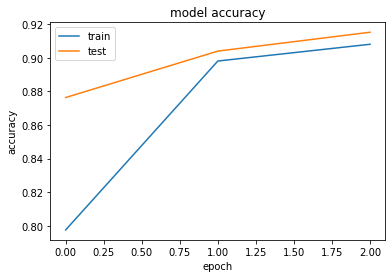

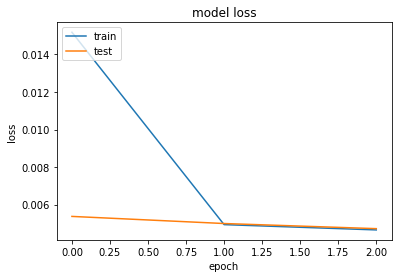

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


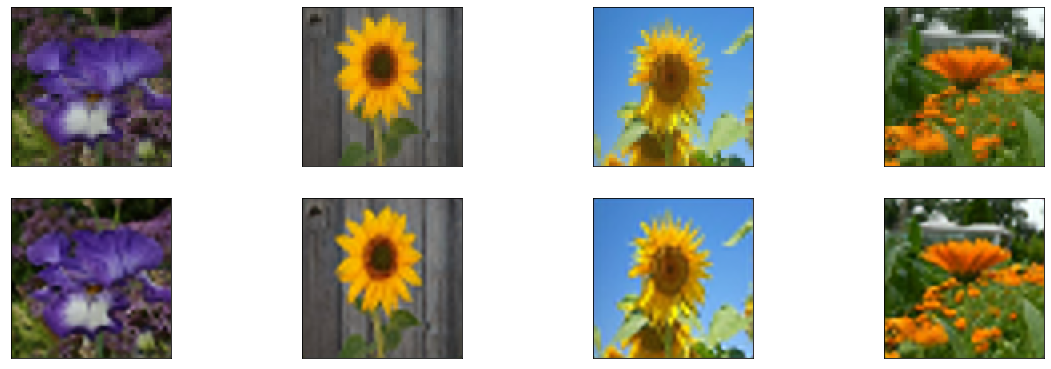

In [50]:
predictions = autoencoder.predict(test_LR_images[:100])
n = 4
plt.figure(figsize=(20, 10))
offset = 59
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(test_LR_images[i+offset])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(predictions[i+offset])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [51]:
num_of_img = 60
custom_metrics(x_test[num_of_img], test_LR_images[num_of_img])
print('-'*30)
custom_metrics(x_test[num_of_img], predictions[num_of_img])

C:\Users\OlegPC\AppData\Local\Temp\ipykernel_8276\3815791103.py:7: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = ssim(f, s, multichannel=True)


psnr 73.98460311033388
mse 0.007793656921386719
ssim 0.8325505256652832
------------------------------
psnr 75.02488250147879
mse 0.006133570098876953
ssim 0.8522089123725891


In [53]:
res = autoencoder.evaluate(test_LR_images, x_test)
print(f'val_loss = {res[0]}, val_accuracy = {res[1]}')

346/346 [==============================] - 928s 3s/step - loss: 0.0047 - accuracy: 0.9153
val_loss = 0.004719508811831474, val_accuracy = 0.9152722358703613


Проверим модель повышения качества изображения на картинке, взятой из открытых источников

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


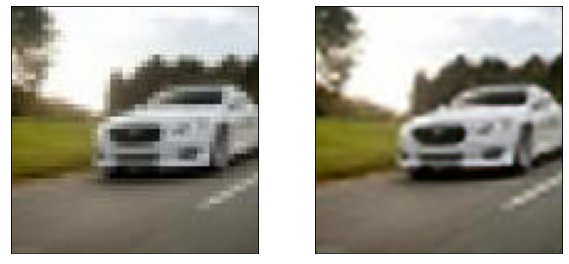

In [77]:
fl_im = np.array(img_to_arr('car3.jpg'))
input_array = np.array([fl_im])
pred = autoencoder.predict(input_array)
plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 2, 1)
plt.imshow(fl_im)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(2, 2, 2)
plt.imshow(pred[0])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()